Shanmukha Bodapati
Raghav Sriram
CS 4372.501
Assignment 3

In [1]:
# This notebook uses the Dog Breed Identification dataset from Kaggle
# Source - https://www.kaggle.com/competitions/dog-breed-identification/overview

In [2]:
# Installation to unzip the zipped data files
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 138 kB 64.0 MB/s 
     |████████████████████████████████| 357 kB 55.2 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 379 kB 49.6 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 2.3 MB 44.6 MB/s 


In [3]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os

In [4]:
# Read in the labels of the training data
train_labels = pd.read_csv('https://github.com/sriram-raghav/CNN-Image-Classification/blob/main/labels.csv?raw=true')
train_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# Find the classes for the Dog Breed Identification dataset
# There are a total of 120 classes
unique_classes = train_labels['breed'].unique()
unique_classes

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [6]:
# Read in the zipped training data
train_response = requests.get("https://neuralnetworkdataa3.s3.amazonaws.com/dog_train.7z", stream=True)
with open("/content/train_data.7z", 'wb') as dir:
    for chunk in train_response.iter_content(chunk_size=128):
        dir.write(chunk)

# Read in the zipped testing data
test_response = requests.get("https://neuralnetworkdataa3.s3.amazonaws.com/dog_test.7z", stream=True)
with open("/content/test_data.7z", 'wb') as dir:
    for chunk in test_response.iter_content(chunk_size=128):
        dir.write(chunk)

In [7]:
# Use py7zr to unzip the contents of the training and testing data
!py7zr x /content/train_data.7z
!py7zr x /content/test_data.7z

In [8]:
# Format the training data directory for input to image_dataset_from_directory

# Create directories for each class
for class_name in unique_classes:
  class_path = os.path.join('/content/train', class_name)
  os.mkdir(class_path)

# Insert all the images into their correct folders
for index, row in train_labels.iterrows():
  source_path = os.path.join('/content/train', str(row['id']) + ".jpg")
  target_path = os.path.join('/content/train', row['breed'], str(row['id']) + ".jpg")
  os.replace(source_path, target_path)

In [9]:
# Read in the training data as a tensorflow.data.Dataset
train_data = tf.keras.utils.image_dataset_from_directory('/content/train', labels = 'inferred',
                                                         label_mode = 'categorical',
                                                         batch_size = 128,
                                                         image_size = (256, 256),
                                                         validation_split=0.1,
                                                         subset="training",
                                                         seed=10,
                                                         shuffle = True)

# Read in the testing data as a tensorflow.data.Dataset 
test_data = tf.keras.utils.image_dataset_from_directory('/content/train', labels = 'inferred',
                                                         label_mode = 'categorical',
                                                         batch_size = 128,
                                                         image_size = (256, 256),
                                                         validation_split=0.1,
                                                         subset="validation",
                                                         seed=10,
                                                         shuffle = True)

Found 10222 files belonging to 120 classes.
Using 9200 files for training.
Found 10222 files belonging to 120 classes.
Using 1022 files for validation.


In [10]:
# Create a model with the given parameters
def create_model(activation='softmax', learning_rate=0.001, rho=0.9, epsilon=1e-07, dropout=0.2):
  # Create a base model using the pre-trained Inception ResNet V2 model from TensorFlow Hub
  image_shape = (256, 256, 3)
  base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape = image_shape,
                                                include_top=False,
                                                weights='imagenet')

  # Make the performance of the dataset better using tensorflow.data.AUTOTUNE
  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_data.prefetch(buffer_size=AUTOTUNE)

  # Rescale the values to be in [-1,1] as this is what MobileNetV2 will use
  preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

  # Freeze the convolutional base and prevent the weights of the layers from changing during training
  base_model.trainable = False

  # Add data augmentation layers to increase the amount of data we have for each class
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Apply a Normalization layer
  normalization_layer = tf.keras.layers.Normalization()

  # Apply a Global Max Pooling layer to produce down sampled feature maps
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # Apply a prediction layer that results in an output of size 120 (matching our categorical one-hot encoded label vector)
  prediction_layer = tf.keras.layers.Dense(120, activation=activation)

  # Apply a dropout layer to prevent overfitting
  dropout_layer = tf.keras.layers.Dropout(dropout)

  # Apply all the layers we have to the base model and create our actual model
  inputs = tf.keras.Input(shape=(256, 256, 3))
  result = data_augmentation(inputs)
  result = normalization_layer(result)
  result = preprocess_input(result)
  result = base_model(result, training=False)
  result = global_average_layer(result)
  result = dropout_layer(result) 
  outputs = prediction_layer(result)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # Compile the model and use CategoricalCrossEntropy loss, the RMSprop optimizer with given settings, and accuracy metric
  # Run the training data with 5 epochs
  model.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon), 
                metrics=['accuracy'])
  history = model.fit(train_dataset, epochs = 10)

  return model, history

In [11]:
# Plot the training accuracies and losses
def training_plots(accuracy, loss, iteration):
  # Plot the training accuracies
  plt.rcParams["figure.figsize"] = (8, 8)
  matplotlib.figure.Figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.tight_layout(pad=5)
  plt.plot(accuracy)
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Iteration ' + str(iteration) + ' Training Accuracy')

  # Plot the training losses
  plt.subplot(2, 1, 2)
  plt.plot(loss)
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.ylim([0,5])
  plt.title('Iteration ' + str(iteration) + ' Training Loss')
  plt.show()

def testing_accuracy(model, test_data):
  loss, accuracy = model.evaluate(test_data)
  print('Test accuracy :', accuracy)

  return loss, accuracy

219055592/219055592 [==============================] - 10s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                        

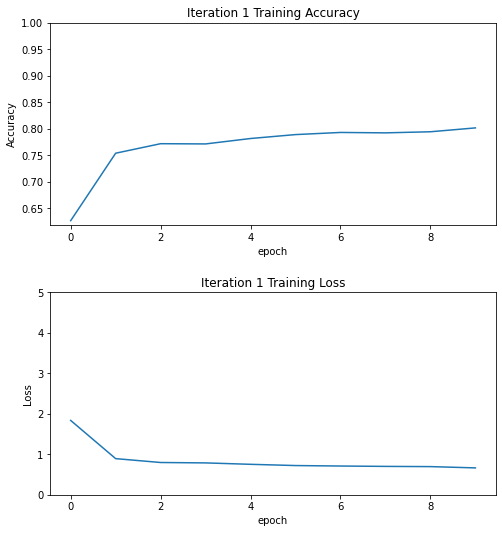

8/8 [==============================] - 15s 1s/step - loss: 0.3429 - accuracy: 0.9012
Test accuracy : 0.9011741876602173


In [12]:
# Keep track of final training and testing accuracies and losses
iteration_training_acc = []
iteration_training_loss = []
iteration_test_acc = []
iteration_test_loss = []

# Run the first model with all default values
model, history = create_model()
training_plots(history.history['accuracy'], history.history['loss'], 1)
iteration_training_acc.append(history.history['accuracy'][-1])
iteration_training_loss.append(history.history['loss'][-1])
loss, accuracy = testing_accuracy(model, test_data)
iteration_test_acc.append(accuracy)
iteration_test_loss.append(loss)

In [13]:
# Get a subset of the first 25 images in the test data and their true labels
unbatched_test_data = list(test_data.unbatch().take(25))
image_batch = []
label_batch = []
for image, label in unbatched_test_data:
  image_batch.append(image)
  label_batch.append(label)
image_batch = np.array(image_batch)
true_labels = []
for i in range(25):
  true_labels.append(test_data.class_names[np.argmax(label_batch[i])])

In [14]:
# Get the predicted classes of the first 25 images in the test data
predictions = model.predict_on_batch(image_batch)

predicted_labels = []
for x in predictions:
  predicted_labels.append(test_data.class_names[np.argmax(x)])

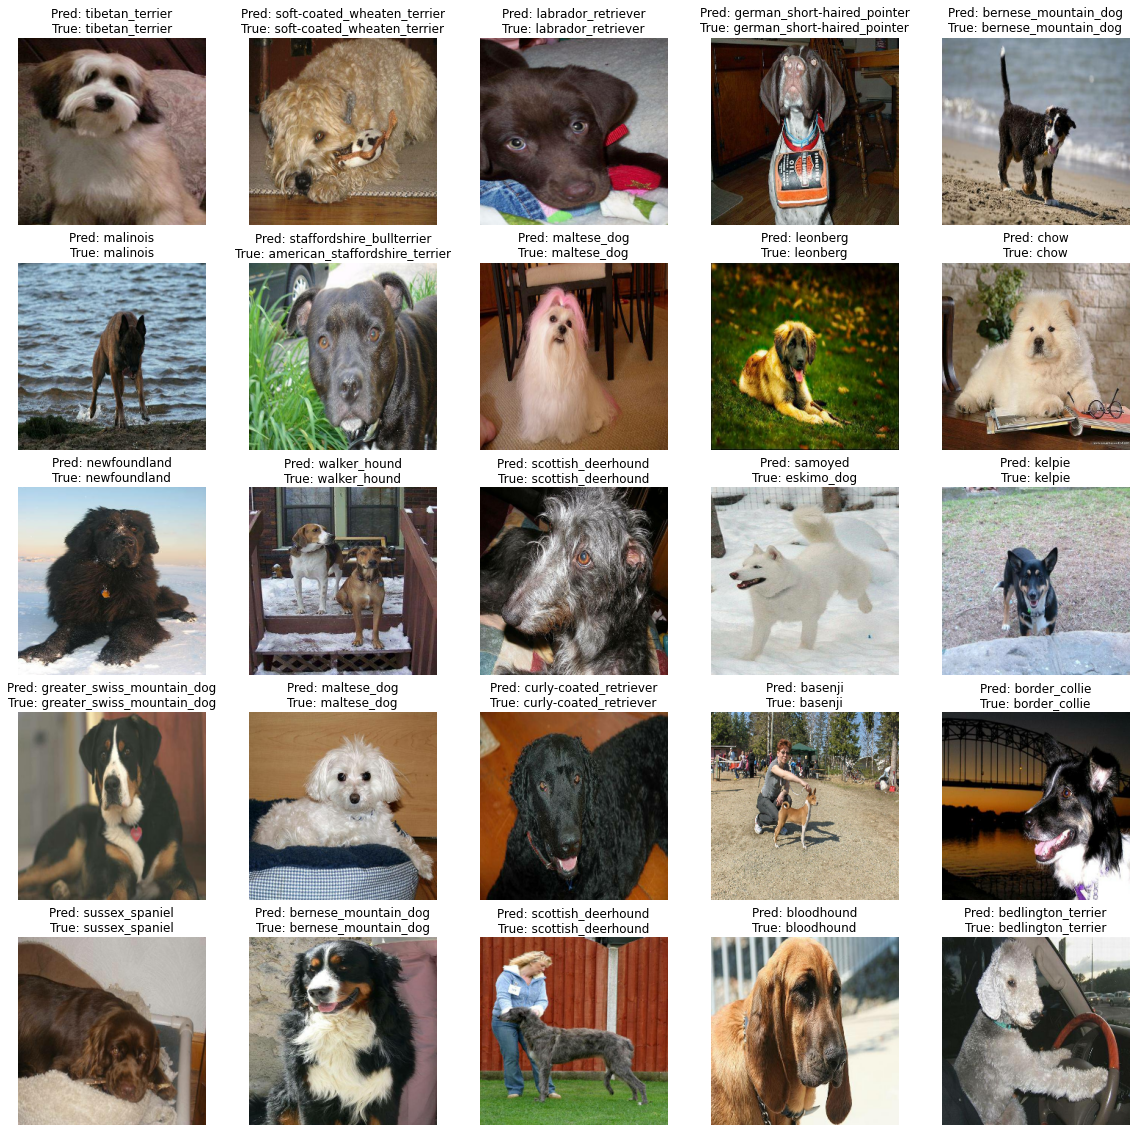

In [15]:
# Plot the first 25 images of the test data along with their predicted and true labels
# Predicted label is shown first and true label is shown last
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Pred: " + predicted_labels[i] + "\nTrue: " + true_labels[i])
  plt.axis("off")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 normalization_1 (Normalizat  (None, 256, 256, 3)      7         
 ion)                                                            
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                           

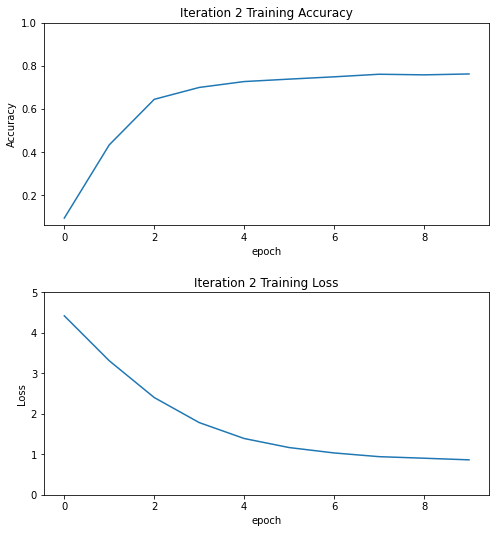

8/8 [==============================] - 11s 860ms/step - loss: 0.3789 - accuracy: 0.9002
Test accuracy : 0.9001957178115845


In [16]:
# Using softmax activation and other tuned values
model, history = create_model("softmax", 0.0001, 0.9, 1e-07, 0.2)
training_plots(history.history['accuracy'], history.history['loss'], 2)
iteration_training_acc.append(history.history['accuracy'][-1])
iteration_training_loss.append(history.history['loss'][-1])
loss, accuracy = testing_accuracy(model, test_data)
iteration_test_acc.append(accuracy)
iteration_test_loss.append(loss)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 normalization_2 (Normalizat  (None, 256, 256, 3)      7         
 ion)                                                            
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                           

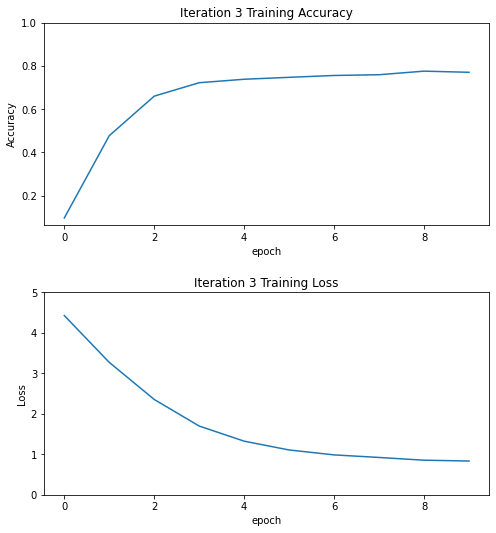

8/8 [==============================] - 11s 860ms/step - loss: 0.3725 - accuracy: 0.8933
Test accuracy : 0.89334636926651


In [17]:
# Using softmax activation and other tuned values
model, history = create_model("softmax", 0.0001, 0.7, 1e-07, 0.1)
training_plots(history.history['accuracy'], history.history['loss'], 3)
iteration_training_acc.append(history.history['accuracy'][-1])
iteration_training_loss.append(history.history['loss'][-1])
loss, accuracy = testing_accuracy(model, test_data)
iteration_test_acc.append(accuracy)
iteration_test_loss.append(loss)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 normalization_3 (Normalizat  (None, 256, 256, 3)      7         
 ion)                                                            
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                           

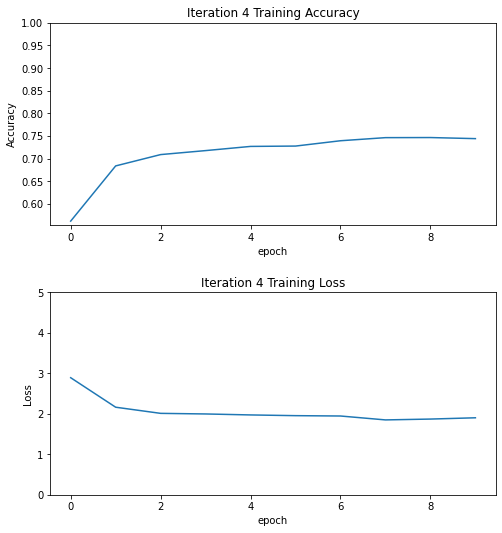

8/8 [==============================] - 11s 856ms/step - loss: 0.7453 - accuracy: 0.8894
Test accuracy : 0.8894324898719788


In [18]:
# Using softmax activation and other tuned values
model, history = create_model("softmax", 0.01, 0.5, 1e-07, 0.2)
training_plots(history.history['accuracy'], history.history['loss'], 4)
iteration_training_acc.append(history.history['accuracy'][-1])
iteration_training_loss.append(history.history['loss'][-1])
loss, accuracy = testing_accuracy(model, test_data)
iteration_test_acc.append(accuracy)
iteration_test_loss.append(loss)

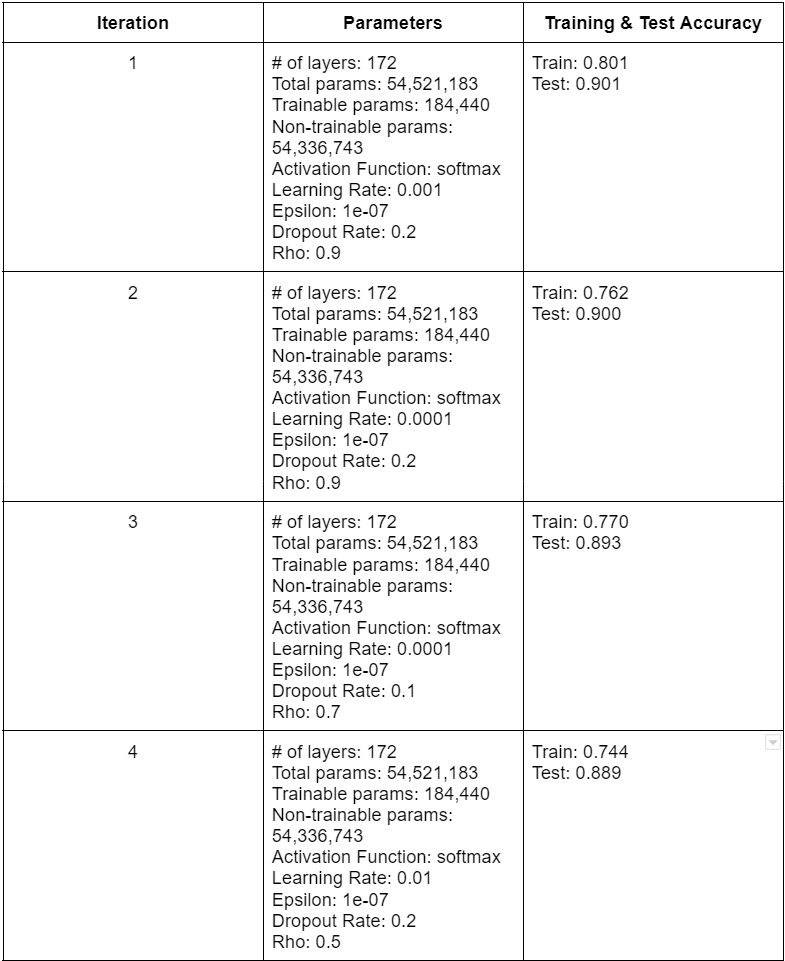

Text(0.5, 1.0, 'Training and Testing Losses')

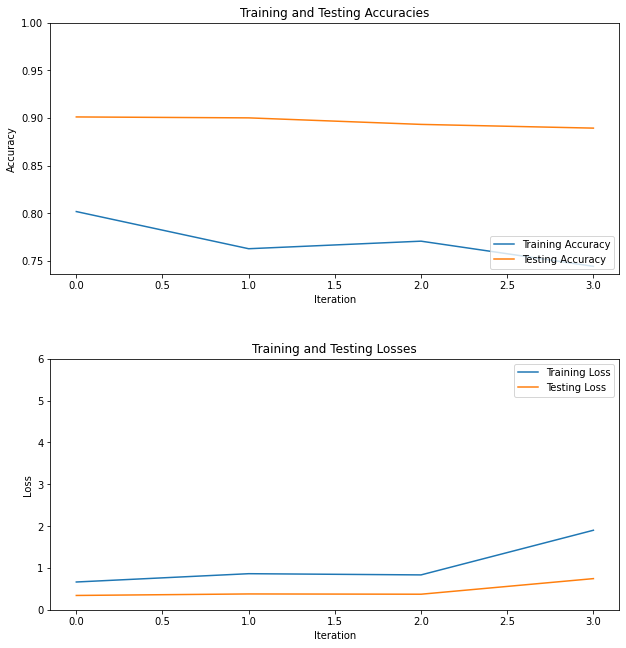

In [19]:
# Plot the final training and testing accuracies
plt.rcParams["figure.figsize"] = (10, 10)
matplotlib.figure.Figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.tight_layout(pad=5)
plt.plot(iteration_training_acc, label='Training Accuracy')
plt.plot(iteration_test_acc, label='Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracies')

# Plot the final training and testing losses
plt.subplot(2, 1, 2)
plt.tight_layout(pad=5)
plt.plot(iteration_training_loss, label='Training Loss')
plt.plot(iteration_test_loss, label='Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.ylim([0,6])
plt.legend(loc='upper right')
plt.title('Training and Testing Losses')